In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.utils import dropna
import matplotlib.pyplot as plt
from ta.volatility import AverageTrueRange

In [54]:
# Load data
data = yf.download("EURUSD=x", period="5d", interval="1h")
data.index = pd.to_datetime(data.index)
data = data.drop(columns=['Adj Close', 'Volume'])
data = dropna(data)

[*********************100%%**********************]  1 of 1 completed


In [55]:
# Define parameters
periods = 10
multiplier = 3.0
change_atr = True
show_signals = True
highlighting = True


In [56]:
# Calculate ATR
atr = AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=periods)
data['atr'] = atr.average_true_range()


In [57]:
# Calculate SuperTrend
data['up'] = np.nan
data['dn'] = np.nan
data['trend'] = np.nan

# Initialize 'up' and 'dn' for the first row
data.loc[0, 'up'] = data.loc[0, 'Close'] + multiplier * data.loc[0, 'atr']
data.loc[0, 'dn'] = data.loc[0, 'Close'] - multiplier * data.loc[0, 'atr']
data.loc[0, 'trend'] = np.nan  # or any other default value

for i in range(1, len(data)):
    # Calculate 'up' value
    data.loc[i, 'up'] = (
        data.loc[i-1, 'up'] 
        if data.loc[i-1, 'up'] > data.loc[i, 'Close'] - multiplier * data.loc[i, 'atr'] 
        else data.loc[i, 'Close'] - multiplier * data.loc[i, 'atr']
    )

    # Calculate 'dn' value
    data.loc[i, 'dn'] = (
        data.loc[i-1, 'dn'] 
        if data.loc[i-1, 'dn'] < data.loc[i, 'Close'] + multiplier * data.loc[i, 'atr'] 
        else data.loc[i, 'Close'] + multiplier * data.loc[i, 'atr']
    )

    # Calculate 'trend' value
    data.loc[i, 'trend'] = (
        1 
        if data.loc[i-1, 'trend'] == -1 and data.loc[i, 'Close'] > data.loc[i-1, 'dn'] 
        else -1 
        if data.loc[i-1, 'trend'] == 1 and data.loc[i, 'Close'] < data.loc[i-1, 'up'] 
        else data.loc[i-1, 'trend'] if not np.isnan(data.loc[i-1, 'trend']) else np.nan
    )

KeyError: 0

In [5]:
# Plot SuperTrend
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close')
plt.plot(data['up'], label='Up Trend', color='green')
plt.plot(data['dn'], label='Down Trend', color='red')

# Plot buy/sell signals
buy_signal = (data['trend'] == 1) & (data['trend'].shift(1) == -1)
sell_signal = (data['trend'] == -1) & (data['trend'].shift(1) == 1)

plt.scatter(data.index[buy_signal], data['Close'][buy_signal], label='Buy', marker='^', color='g')
plt.scatter(data.index[sell_signal], data['Close'][sell_signal], label='Sell', marker='v', color='r')

plt.legend()
plt.show()


C:\Users\Peace Pearl\AppData\Local\Temp\ipykernel_19596\763133607.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Trend'][0] = 1  # Starting with an uptrend
C:\Users\Peace Pearl\AppData\Local\Temp\ipykernel_19596\763133607.py:3: Fu

In [6]:
# Calculate Trend and SuperTrend
for i in range(1, len(data)):
    prev_trend = data['Trend'][i-1]
    prev_up = data['Up'][i-1]
    prev_dn = data['Dn'][i-1]
    close = data['Close'][i-1]
    
    # SuperTrend conditions
    if prev_trend == 1:
        data['Up'][i] = max(data['Up'][i], prev_up)
        if close < data['Up'][i]:
            data['Trend'][i] = -1
        else:
            data['Trend'][i] = 1
    elif prev_trend == -1:
        data['Dn'][i] = min(data['Dn'][i], prev_dn)
        if close > data['Dn'][i]:
            data['Trend'][i] = 1
        else:
            data['Trend'][i] = -1

C:\Users\Peace Pearl\AppData\Local\Temp\ipykernel_19596\3851898991.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_trend = data['Trend'][i-1]
C:\Users\Peace Pearl\AppData\Local\Temp\ipykernel_19596\3851898991.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_up = data['Up'][i-1]
C:\Users\Peace Pearl\AppData\Local\Temp\ipykernel_19596\3851898991.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_dn = data['Dn'][

In [7]:
# Signals
data['BuySignal'] = (data['Trend'] == 1) & (data['Trend'].shift(1) == -1)
data['SellSignal'] = (data['Trend'] == -1) & (data['Trend'].shift(1) == 1)

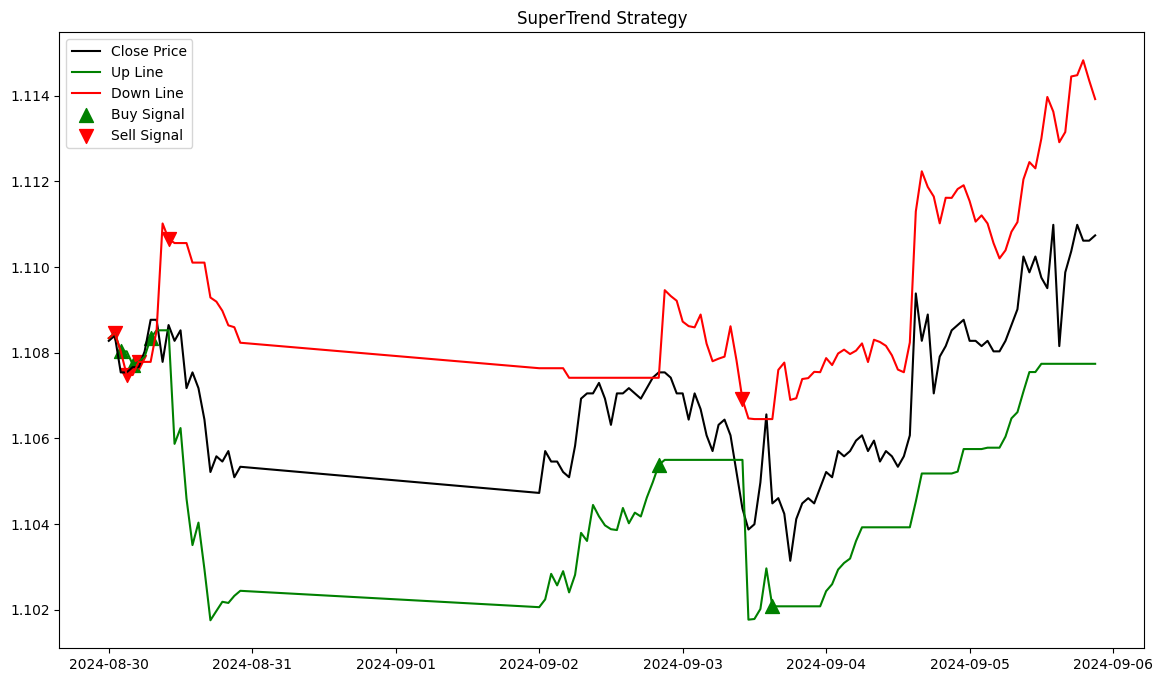

In [8]:
# Plotting the data
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Close'], label='Close Price', color='black')
plt.plot(data.index, data['Up'], label='Up Line', color='green')
plt.plot(data.index, data['Dn'], label='Down Line', color='red')
plt.scatter(data.index[data['BuySignal']], data['Up'][data['BuySignal']], marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(data.index[data['SellSignal']], data['Dn'][data['SellSignal']], marker='v', color='red', label='Sell Signal', s=100)
plt.title("SuperTrend Strategy")
plt.legend(loc='best')
plt.show()